# Прогнозирование уровня средней заработной платы в России

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.
#### Алгоритм построения прогноза:

1. Визуальный анализ ряда

2. Стабилизация дисперсии (при необходимости)

3. Выбор порядка дифференцирования

4. Выбор начальных приближений для p, q, P, Q

5. Обучение и сравнение моделей-кандидатов, выбор победителя

6. Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p, q, P, Q.

7. Прогнозирование с помощью финальной модели.

In [29]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product
import warnings

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

In [5]:
data = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

/home/bebra/mambaforge-pypy3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


In [7]:
data.describe()

,WAG_C_M
count,284.000000
mean,12193.308099
std,11992.326701
min,15.300000
25%,1191.000000
50%,7195.000000
75%,21365.250000
max,43408.000000


### Визуальный анализ ряда

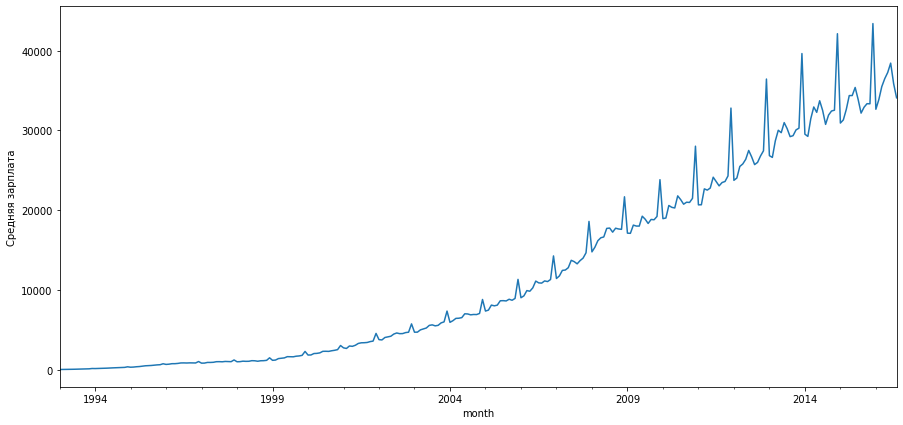

In [11]:
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
plt.ylabel("Средняя зарплата")
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Дики-Фуллера критерий: p=0.991850


<Figure size 1080x720 with 0 Axes>

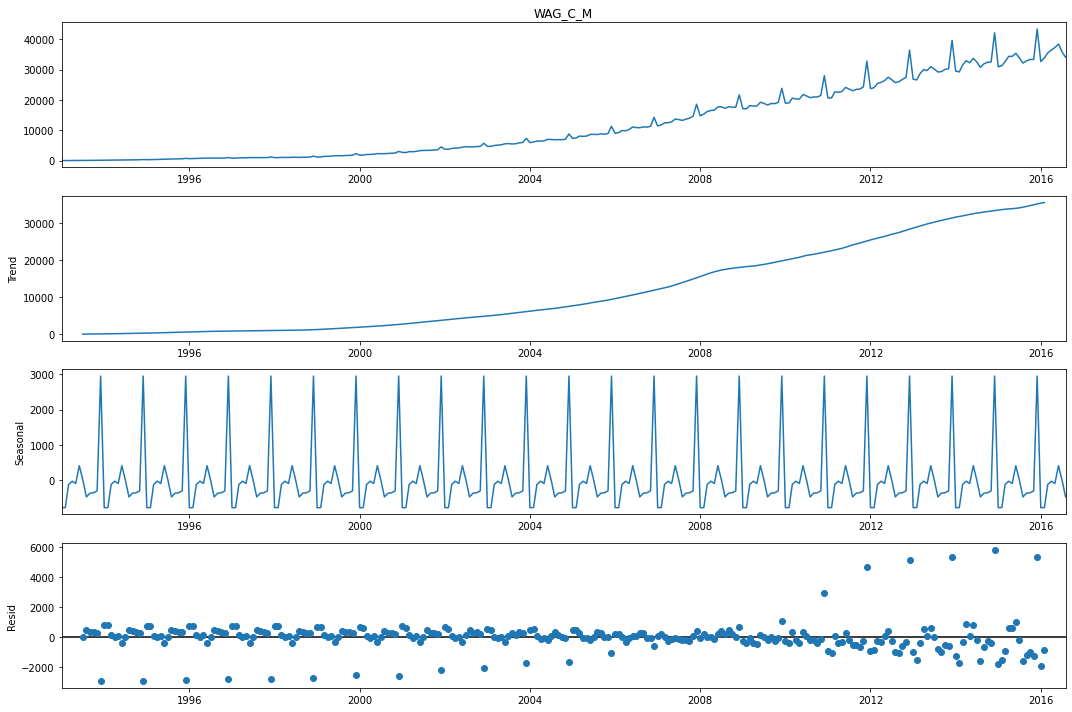

In [20]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Дики-Фуллера критерий: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

Гипотеза о стационарности отвергается, так как критерий Дики Фуллера выше 0.05

### Стабилизация дисперсии

Применим преобразование Бокса-Кокса:

Параметр преобразования Бокса-Кокса: 0.263202
Дики-Фуллера: p=0.696899


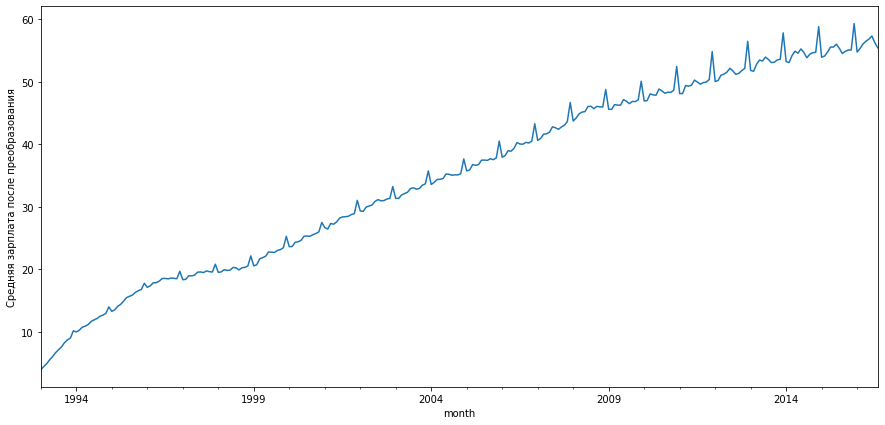

In [21]:
data['wage_box'], lymbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.wage_box.plot()
plt.ylabel(u'Средняя зарплата после преобразования')
print("Параметр преобразования Бокса-Кокса: %f" % lymbda)
print("Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box)[1])

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

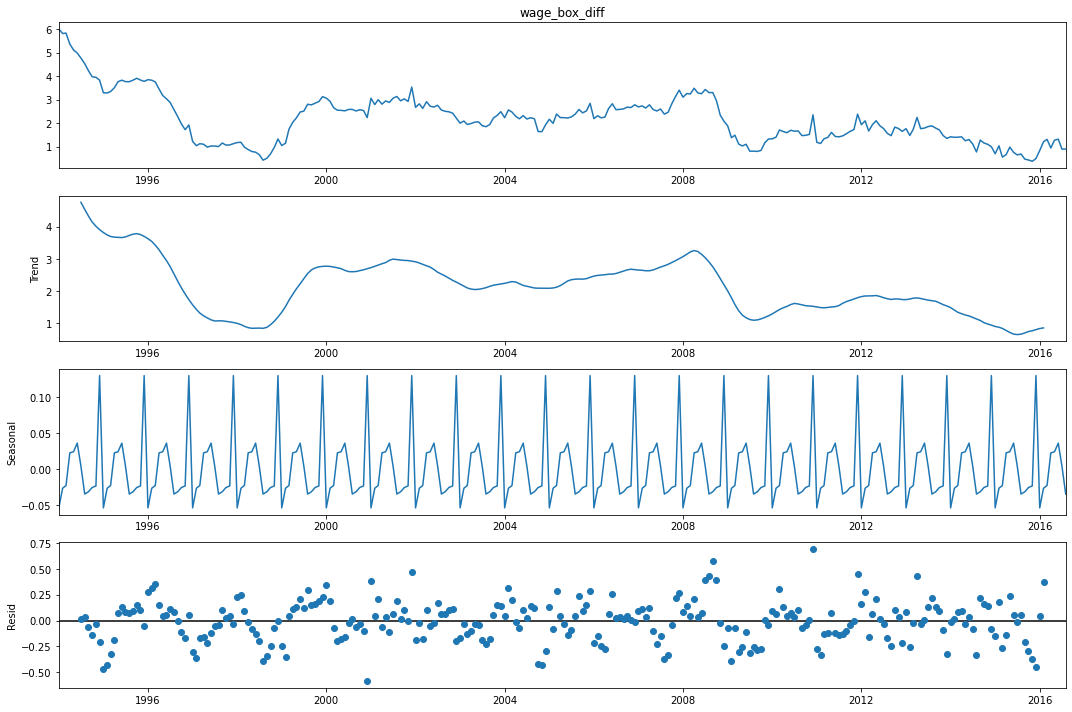

In [22]:
data['wage_box_diff'] = data.wage_box - data.wage_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wage_box_diff[12:]).plot()
print("Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

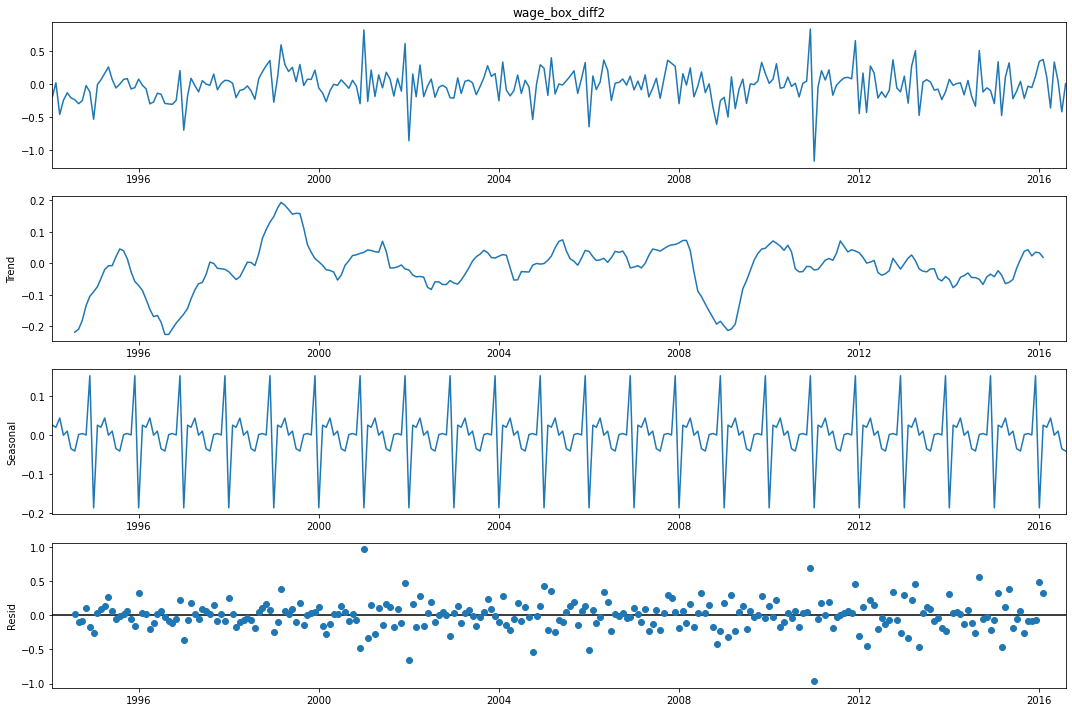

In [23]:
data['wage_box_diff2'] = data.wage_box_diff - data.wage_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wage_box_diff2[13:]).plot()
print("Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box_diff2[13:])[1])

### Подбор модели

Посмотрим на ACF и PACF полученного ряда:

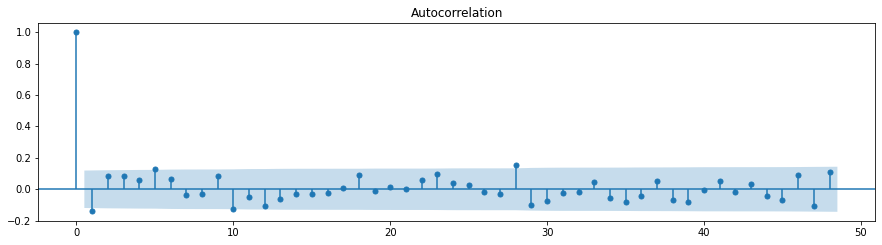

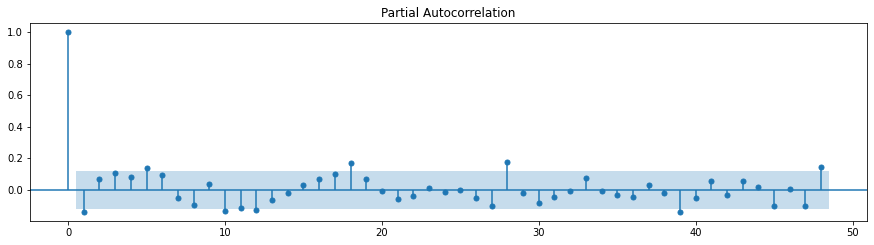

In [24]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

анализируя графики возьмем следующие начальные приближения: Q=0, q=1, P=1, p=1.

In [25]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [31]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [32]:
results = []
better_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data.wage_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    if aic < better_aic:
        better_model = model
        better_aic = aic
        better_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print('______________________')
print('\n')
print('better model: ')
print(better_model.summary())

     parameters       aic
5  (1, 0, 1, 0)  0.340521
3  (0, 1, 1, 0)  1.170768
7  (1, 1, 1, 0)  2.021911
4  (1, 0, 0, 0)  2.625709
2  (0, 1, 0, 0)  3.369832
______________________


better model: 
                                     SARIMAX Results                                      
Dep. Variable:                           wage_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Thu, 07 Oct 2021   AIC                              0.341
Time:                                    17:08:03   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.97

Её остатки:

Критерий Стьюдента: 0.090795
Критерий Дики-Фуллера: 0.000003


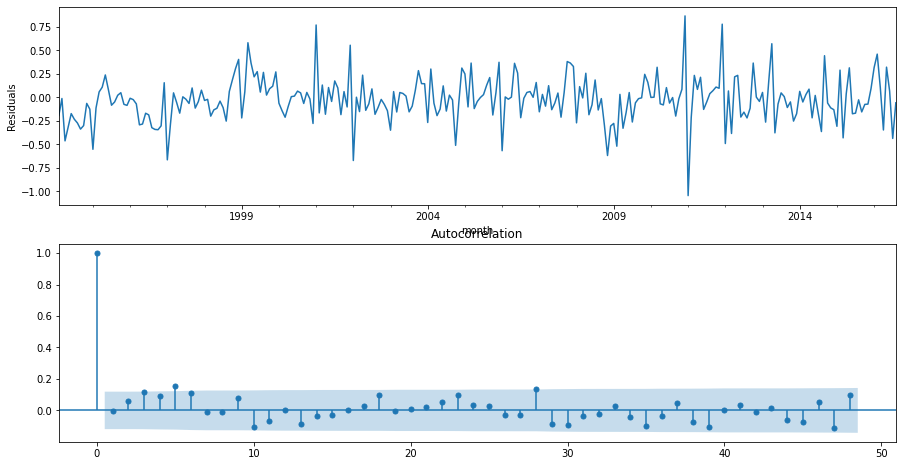

In [33]:
plt.figure(figsize(15,8))
plt.subplot(211)
better_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(better_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: %f" % stats.ttest_1samp(better_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: %f" % sm.tsa.stattools.adfuller(better_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

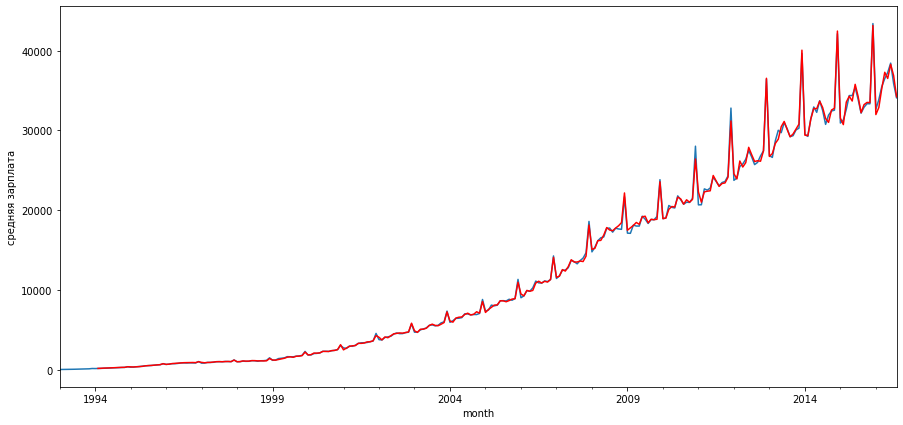

In [36]:
data['model'] = inv_box_cox(better_model.fittedvalues, lymbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('средняя зарплата')
pylab.show()

## Прогнозирование с помощью финальной модели

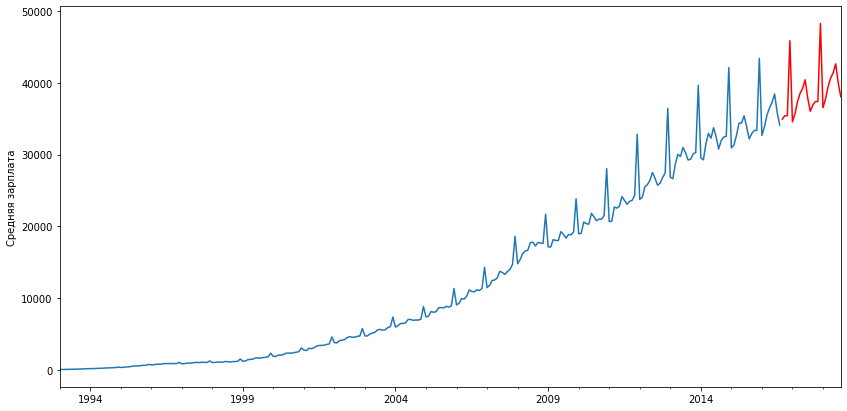

In [42]:
data_1 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
for_2019 = pd.DataFrame(index=date_list, columns= data_1.columns)
data_1 = pd.concat([data_1, for_2019])
data_1['forecast'] = inv_box_cox(better_model.predict(start=284, end=308), lymbda)

plt.figure(figsize(14,7))
data_1.forecast.plot(color='r')
plt.ylabel('Cредняя зарплата')
data_1.WAG_C_M.plot()
pylab.show()